# Binary classification test

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import seaborn as sns

## Introduction

Binary predictors are a key tool in classification problems. These predictors are central to a variety of applications, from disease diagnosis to financial forecasting. In this computer lab, we will attempt to assess the quality of a set of binary predictors on balanced and unbalanced datasets using the quality estimators and metrics we defined in the previous class.

## Experimental setup

We will create an artificial dataset with two clusters in high dimensions. We will assign a label 0 and 1 to each of these clusters and the goal is to evaluate the performance of different predictors to classify which entry belongs to each cluster. In the lab, we will firstly evaluate the quality of the predictions and secondly fine tune the parameters to optimize the performance of each predictor. In the end, we will decide which predictor is the best of all.

We plan to study the following predictors:

#### 1. Random assignment

- **Strategy:** Randomly assign label 1 based on a predefined probability \( p \).
- **Parameter to Tune:** The probability \( p \) of choosing label 1.

#### 2. PCA-based predictor

- **Strategy:** Use principal component analysis (PCA) to assign label 1 based on the first principal component (PC1).
- **Parameter to Tune:** The threshold \( a \) so that label 1 is selected when PC1 < \( a \).

#### 3. Logistic Regression

- **Strategy:** Implement logistic regression to estimate the probability that a given entry belongs to label 1.
- **Tuning parameter:** The threshold for determining the label based on the estimated probability.

---

## Next steps:

1. Define our data set
2. Define the different predictors
3. Define the various quality metrics discussed in the previous class.
4. Evaluate each predictor and optimize the parameters



## 1. Generation of our dataset

We generate 2 random clusters for a binary test classification

(10000, 20)


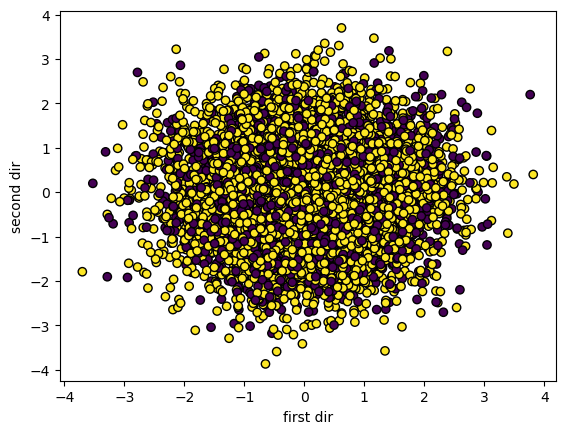

In [2]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Setting the probability for the true class
Prob_true = 0.7

# Generating the n_samples in 20 dimensions belonging to 2 categories  
X, y = make_classification(n_features=20,n_samples=10000, n_classes=2, #n_clusters_per_class=1,class_sep=1.5,
                           weights=[1-Prob_true,Prob_true],random_state=0)

print(X.shape)
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)


# Plotting the generated data
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, edgecolors='k')
plt.xlabel('first dir')
plt.ylabel('second dir')
plt.show()



We can check that there are two clases of data-points using dimensional reduction, for instance the PCA (we will study its meaning later on in the course)

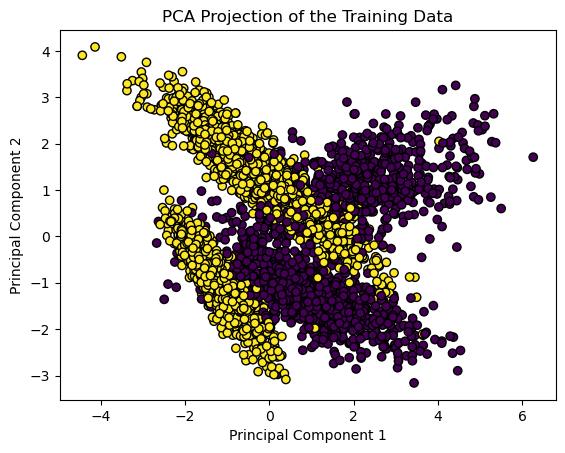

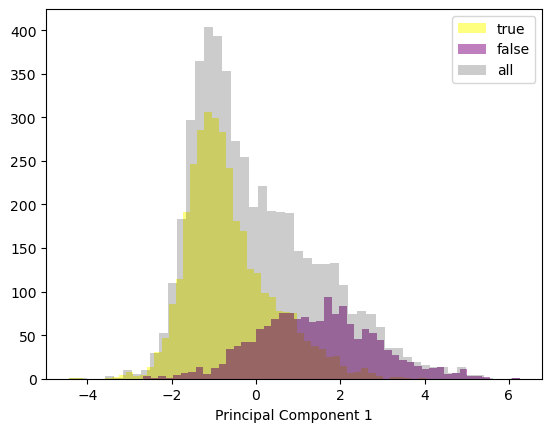

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)


# Plotting the training data in the new PCA space
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], marker='o', c=y_train, edgecolors='k')
plt.title('PCA Projection of the Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


index_1=(y_train==1)
index_0=(y_train==0)


plt.hist(X_train_pca[index_1, 0],bins=50,color='yellow',alpha=0.5,label='true')
plt.hist(X_train_pca[index_0, 0],bins=50,color='purple',alpha=0.5,label='false')
plt.hist(X_train_pca[:, 0],bins=50,color='black',alpha=0.2,label='all')
plt.legend()
plt.xlabel('Principal Component 1')
plt.show()



## 2. Define different predictors

We need to define our 3 different predictors.

### No skills

I want a predictor that just assign 1 with a random probability $p$

In [4]:
def no_skills(X,p=0.5):
    return np.array(np.random.choice([0,1],size=len(X),p=[1-p,p]))

### Naive: PCA based predictor

In [5]:
def PCA_based(X,threshold):
    pca = PCA(n_components=1)
    X_pca = pca.fit_transform(X).reshape(len(X))
    
    return (X_pca<threshold).astype(int)

### Training: Logistic regression

We can learn to classify this data using logistic regression. I include a discussion about its training but we do not need this for this lab.

Let us describe the data in terms of a probability function
$$p_{A,B}(\boldsymbol{x})=\frac{1}{1+e^{-(A+\boldsymbol{B}\cdot\boldsymbol{x})}},$$ using labeled data $(\boldsymbol{x}_k,y_k)$. We want to train the model such that the probability $p_k=p_{A,B}(\boldsymbol{x}_k)=1$ for $y_k=1$ and 0 for $y_k=0$. For this purpose, we can define a log loss
$$L=-\sum_{k} y_k\log p_k -(1-y_k)\log p_k $$
(it is clear that $L$ is minimized $p_k=1$ when $y_k=1$ and $p_k=0$ when $y_k=0$).
One can then minimize it by calculating the gradient
$$\frac{\partial L}{\partial A}=\sum_k (p_k-y_k)=0$$
$$\frac{\partial L}{\partial \boldsymbol{B}}=\sum_k \boldsymbol{x}_k (p_k-y_k)=0$$
Which is solved numerically. As a result of this process, we obtain a way to assign to each data point a probability of being in the category $y=1$. 

In [6]:
from sklearn.linear_model import LogisticRegression

def logistic(X_test,X_train,y_train):

    clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    clf.fit(X_train, y_train)
    
    y_probs = clf.predict_proba(X_test) #第一列为0的概率，第二列为1的概率

    return y_probs

## 3. Confusion matrix

Now we have a set of two pairs mutually incompatible events: 

- **True cluster** being part of cluster $[0,1]$,
- **Predicted label**: getting $[-,+]$


### Confusion matrices

We need to compute the conditional probablities, e.g. $P(1|+)$, or $P(0|+)$.

Define a function that given the number two vectors containing the categories of the samples in the test set, $y$ and $y_{\rm pred}$, it returns the number of true positives (TP, $N(1\cap +)$), true negatives (TN, $N(0\cap -)$), false positives (FP, $N(0\cap +)$)  and false negatives (FN, $N(1\cap -)$)


In [7]:
def compute_confusion_matrix(y_pred,y_test):
    
    #TP=np.sum((y_pred==y_1)and(y=test==1))
    #FP=np.sum((y_pred==y_1)and(y=test==0))
    #TN=np.sum((y_pred==y_0)and(y=test==0))
    #FN=np.sum((y_pred==y_0)and(y=test==1))
    TP,FP,FN,TN=np.zeros(4)

    for i,y in enumerate(y_test):
        if y==1 and y_pred[i]==1:
            TP +=1
        if y==1 and y_pred[i]==0:
            FN +=1
        if y==0 and y_pred[i]==0:
            TN +=1
        if y==0 and y_pred[i]==1:
            FP +=1
    
    return TN,FP,FN,TP

print(compute_confusion_matrix(y_test,y_test))




(1483.0, 0.0, 0.0, 3517.0)


We can visualize the confusion matrix 

<table>
  <tr>
    <th></th>
    <th>Pred -</th>
    <th>Pred +</th>
  </tr>
  <tr>
    <th>Real 0</th>
    <td>TNR </td>
    <td>FPR </td>
  </tr>
  <tr>
    <th>Real 1</th>
    <td>FNR </td>
    <td>TPR</td>
  </tr>
</table>
It is more convenient to divide by the total number of entries to have an idea of the proportions.


for 3 different predictors:
    
- Random guess with $p=0.99$
- PCA threshold 0
- Logistic $p_1>0.5\rightarrow 1$




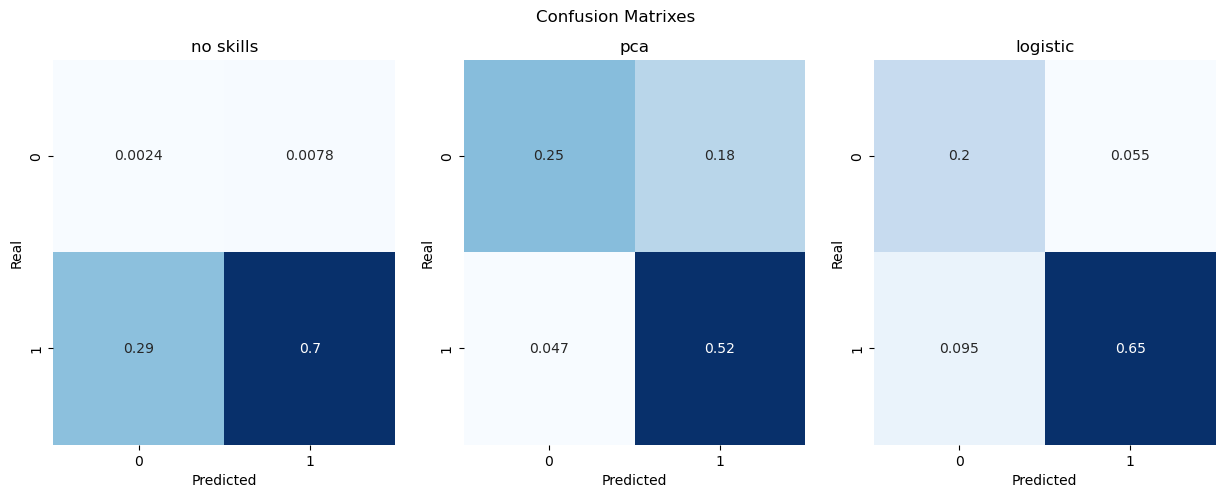

In [8]:

y_pred_r=no_skills(X_test,p=0.99)
y_pred_pca=PCA_based(X_test,0)

probs1_log=logistic(X_test,X_train,y_train)[:,1] # probability of 1
y_pred_l=(probs1_log>0.5).astype(int)

titles=['no skills','pca','logistic']

fig, ax = plt.subplots(1, 3,figsize=(15,5))
for i,y_pred in enumerate([y_pred_r, y_pred_pca,y_pred_l]):
    
    TN,FP,FN,TP=compute_confusion_matrix(y_test,y_pred)
    cm=[[TN,FP],[FN,TP]]

    ax[i].set_title(titles[i])
    sns.heatmap(cm/np.sum(cm), annot=True, cmap="Blues", cbar=False,ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('Real')
plt.suptitle('Confusion Matrixes')
plt.show()

Which is the confusion matrix if both events were completely independent?

Remember that $P(0\cap +)=\frac{P(0\cap +)}{N_T}=P(0|+)P(+)=P(0)P(+)$

<table>
  <tr>
    <th></th>
    <th>Pred -</th>
    <th>Pred +</th>
  </tr>
  <tr>
    <th>Real 0</th>
    <td>𝑃(0)𝑃(-)</td>
    <td>𝑃(0)𝑃(+)</td>
  </tr>
  <tr>
    <th>Real 1</th>
    <td>𝑃(1)𝑃(-)</td>
    <td>𝑃(1)𝑃(+)</td>
  </tr>
</table>



In [9]:
def compute_randomconfusion_matrix(y_pred,y_test):
    
    N=len(y_test)
    prob_pos=np.sum(y_test==1)/N
    prob_neg=np.sum(y_test==0)/N
    
    prob_0_neg_neg=np.sum((y_pred==0) & (y_test==0))/np.sum(y_test==0)
    prob_1_pos_pos=np.sum((y_pred==1) & (y_test==1))/np.sum(y_test==1)
    prob_0_pos_pos=np.sum((y_pred==0) & (y_test==1))/np.sum(y_test==1)
    prob_1_neg_neg=np.sum((y_pred==1) & (y_test==0))/np.sum(y_test==0)
    
    prob_0_neg=prob_0_neg_neg*prob_neg
    prob_1_pos=prob_1_pos_pos*prob_pos
    prob_0_pos=prob_0_pos_pos*prob_pos
    prob_1_neg=prob_1_neg_neg*prob_neg

    confusion_matrix = np.array([[prob_0_neg, prob_0_pos], [prob_1_neg, prob_1_pos]])
    
    return confusion_matrix

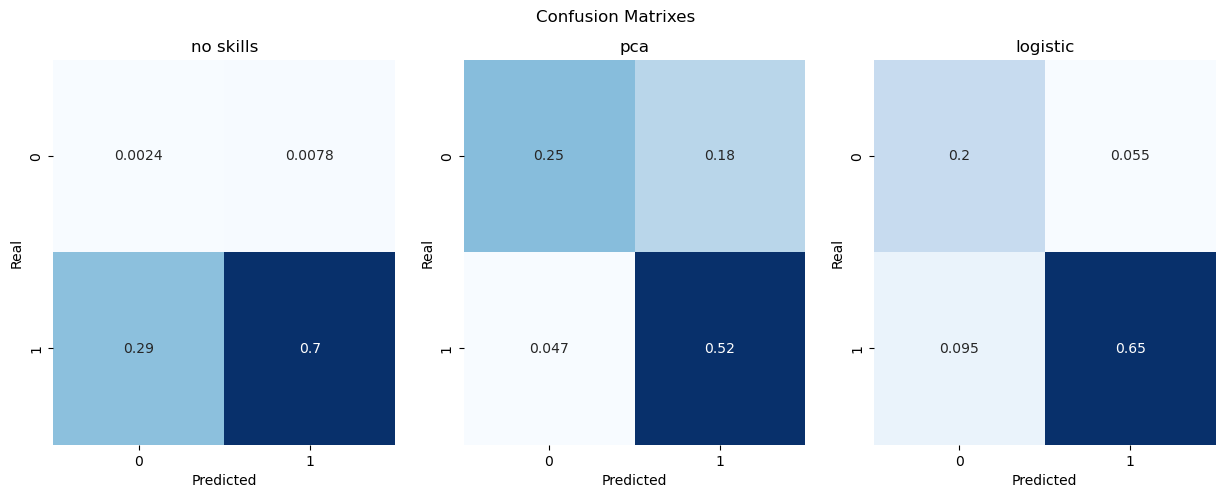

In [10]:
fig, ax = plt.subplots(1, 3,figsize=(15,5))
for i,y_pred in enumerate([y_pred_r, y_pred_pca,y_pred_l]):
    
    cm=compute_randomconfusion_matrix(y_pred,y_test)

    ax[i].set_title(titles[i])
    sns.heatmap(cm, annot=True, cmap="Blues", cbar=False,ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('Real')
plt.suptitle('Confusion Matrixes')
plt.show()



## 4. Quality estimators

Write a function to compute the Sensitivity, Specificity, Precisiono, Negative Positive Value, Accuracy and F1 score, given two vectors of predicted and true labels 

In [11]:
def metrics(y_test, y_pred):
    TP = np.sum((y_pred == 1) & (y_test == 1))

    FP = np.sum((y_pred == 1) & (y_test == 0))
    
    TN = np.sum((y_pred == 0) & (y_test == 0))
    
    FN = np.sum((y_pred == 0) & (y_test == 1))
    
    Sen = TP / (TP + FN) # Sensitivity (Recall)

    Spe = TN / (TN + FP) # Specificity

    Pre = TP / (TP + FP) # Precision
    
    NPV = TN / (TN + FN) # Negative Predictive Value
    
    Acc = (TP + TN) / (TP + TN + FP + FN) # Accuracy
    
    F1 = 2 * (Pre * Sen) / (Pre + Sen)
    
    return Sen,Spe,Pre,NPV,Acc,F1

Which is the baseline for these estimators?

In [12]:
def metrics_baseline(y_test, y_pred):
    # 计算baseline矩阵
    class_distribution = np.sum(y_test) / len(y_test)
    
    Sen_ran = class_distribution
    
    Spe_ran = 1 - class_distribution
    
    Pre_ran = class_distribution
    
    NPV_ran = 1 - class_distribution
    
    Acc_ran = max(class_distribution, 1 - class_distribution)
    
    F1_ran = 2 * (Pre_ran * Sen_ran) / (Pre_ran + Sen_ran)
    
    return Sen_ran,Spe_ran,Pre_ran,NPV_ran,Acc_ran,F1_ran

In [13]:

def quality_estimators(y_test, y_pred):
    
    Sen,Spe,Pre,NPV,Acc,F1= metrics(y_test, y_pred)
    Sen_ran,Spe_ran,Pre_ran,NPV_ran,Acc_ran,F1_ran= metrics_baseline(y_test, y_pred)
     
    
    print("**********************")

    print(f"{'Accuracy:':<25} {Acc * 100:.2f}% ({Acc_ran * 100:.2f}%)")
    print(f"{'F1 Score:':<25} {F1 * 100:.2f}% ({F1_ran * 100:.2f}%)")
    print(f"{'Sensitivity (Recall):':<25} {Sen * 100:.2f}% ({Sen_ran * 100:.2f}%)")
    print(f"{'Precision:':<25} {Pre * 100:.2f}% ({Pre_ran * 100:.2f}%)")
    print(f"{'Specificity:':<25} {Spe * 100:.2f}% ({Spe_ran * 100:.2f}%)")
    print(f"{'NPV:':<25} {NPV * 100:.2f}% ({NPV_ran * 100:.2f}%)")

    print("**********************")


In [14]:

for i,y_pred in enumerate([y_pred_r, y_pred_pca,y_pred_l]):
    print(titles[i])
    quality_estimators(y_test, y_pred)
    

no skills
**********************
Accuracy:                 69.80% (70.34%)
F1 Score:                 82.16% (70.34%)
Sensitivity (Recall):     98.89% (70.34%)
Precision:                70.28% (70.34%)
Specificity:              0.81% (29.66%)
NPV:                      23.53% (29.66%)
**********************
pca
**********************
Accuracy:                 76.98% (70.34%)
F1 Score:                 81.87% (70.34%)
Sensitivity (Recall):     73.90% (70.34%)
Precision:                91.77% (70.34%)
Specificity:              84.29% (29.66%)
NPV:                      57.66% (29.66%)
**********************
logistic
**********************
Accuracy:                 85.00% (70.34%)
F1 Score:                 89.63% (70.34%)
Sensitivity (Recall):     92.12% (70.34%)
Precision:                87.26% (70.34%)
Specificity:              68.11% (29.66%)
NPV:                      78.48% (29.66%)
**********************


## 5. Quality as a function of the parameters

Compute the accuracy of each method as function of the parameters of the predictor

/tmp/ipykernel_366/2765333532.py:14: RuntimeWarning: invalid value encountered in scalar divide
  Pre = TP / (TP + FP) # Precision
/tmp/ipykernel_366/2765333532.py:16: RuntimeWarning: invalid value encountered in scalar divide
  NPV = TN / (TN + FN) # Negative Predictive Value


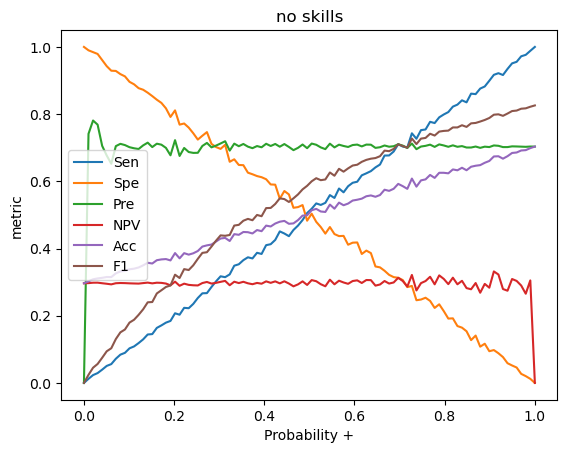

/tmp/ipykernel_366/2765333532.py:14: RuntimeWarning: invalid value encountered in scalar divide
  Pre = TP / (TP + FP) # Precision
/tmp/ipykernel_366/2765333532.py:14: RuntimeWarning: invalid value encountered in scalar divide
  Pre = TP / (TP + FP) # Precision
/tmp/ipykernel_366/2765333532.py:14: RuntimeWarning: invalid value encountered in scalar divide
  Pre = TP / (TP + FP) # Precision
/tmp/ipykernel_366/2765333532.py:14: RuntimeWarning: invalid value encountered in scalar divide
  Pre = TP / (TP + FP) # Precision


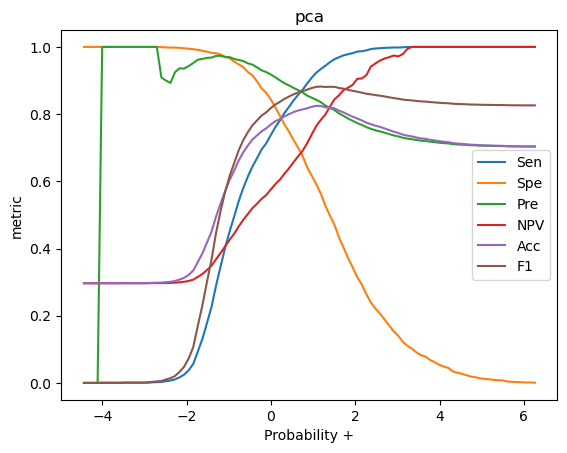

/tmp/ipykernel_366/2765333532.py:16: RuntimeWarning: invalid value encountered in scalar divide
  NPV = TN / (TN + FN) # Negative Predictive Value
/tmp/ipykernel_366/2765333532.py:14: RuntimeWarning: invalid value encountered in scalar divide
  Pre = TP / (TP + FP) # Precision


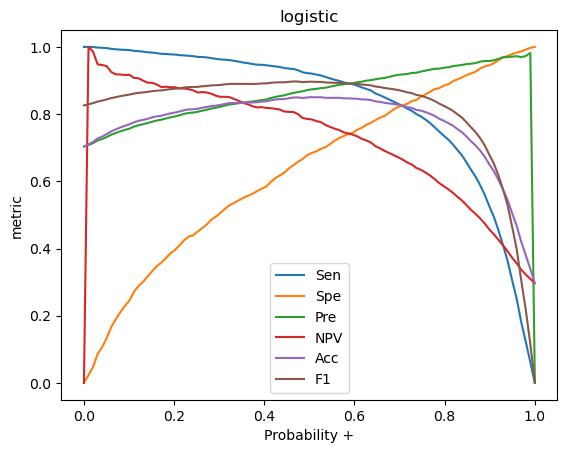

In [15]:
N=100 # number of parameters

## random

range_noskill=np.linspace(0, 1, N)
Metrics_noskill=np.zeros((N,6))
for ith,p in enumerate(range_noskill):
    y_pred_th=no_skills(X_test,p=p)
    Metrics_noskill[ith]=np.nan_to_num(metrics(y_test, y_pred_th))
    
plt.title(titles[0])
plt.plot(range_noskill,Metrics_noskill[:,0],label='Sen')
plt.plot(range_noskill,Metrics_noskill[:,1],label='Spe')
plt.plot(range_noskill,Metrics_noskill[:,2],label='Pre')
plt.plot(range_noskill,Metrics_noskill[:,3],label='NPV')
plt.plot(range_noskill,Metrics_noskill[:,4],label='Acc')
plt.plot(range_noskill,Metrics_noskill[:,5],label='F1')
plt.xlabel('Probability +')
plt.ylabel('metric')
plt.legend()
plt.show()

## pca


range_pca=np.linspace(np.min(X_train_pca[:, 0]), np.max(X_train_pca[:, 0]),N)
Metrics_pca=np.zeros((N,6))
for ith,p in enumerate(range_pca):
    X_test_pca=PCA_based(X_test,threshold=p)
    Metrics_pca[ith]=np.nan_to_num(metrics(y_test,X_test_pca))
    
plt.title(titles[1])
plt.plot(range_pca,Metrics_pca[:,0],label='Sen')
plt.plot(range_pca,Metrics_pca[:,1],label='Spe')
plt.plot(range_pca,Metrics_pca[:,2],label='Pre')
plt.plot(range_pca,Metrics_pca[:,3],label='NPV')
plt.plot(range_pca,Metrics_pca[:,4],label='Acc')
plt.plot(range_pca,Metrics_pca[:,5],label='F1')
plt.xlabel('Probability +')
plt.ylabel('metric')
plt.legend()
plt.show()


## logistic

range_log=np.linspace(0, 1,N)
Metrics_log=np.zeros((N,6))
for ith,p in enumerate(range_log):
    y_probs_log=logistic(X_test, X_train, y_train)
    y_pred_log = (y_probs_log[:, 1] > p).astype(int)
    metrics_values = metrics(y_test, y_pred_log)
    Metrics_log[ith] = np.nan_to_num(metrics_values)
    

plt.title(titles[2])
plt.plot(range_log,Metrics_log[:,0],label='Sen')
plt.plot(range_log,Metrics_log[:,1],label='Spe')
plt.plot(range_log,Metrics_log[:,2],label='Pre')
plt.plot(range_log,Metrics_log[:,3],label='NPV')
plt.plot(range_log,Metrics_log[:,4],label='Acc')
plt.plot(range_log,Metrics_log[:,5],label='F1')
plt.xlabel('Probability +')
plt.ylabel('metric')
plt.legend()
plt.show()


range_pca=np.linspace(np.min(X_train_pca[:, 0]), np.max(X_train_pca[:, 0]),N)


## 5. ROC

For each of the predictors, plot the Sensitivity vs. 1-Specificity

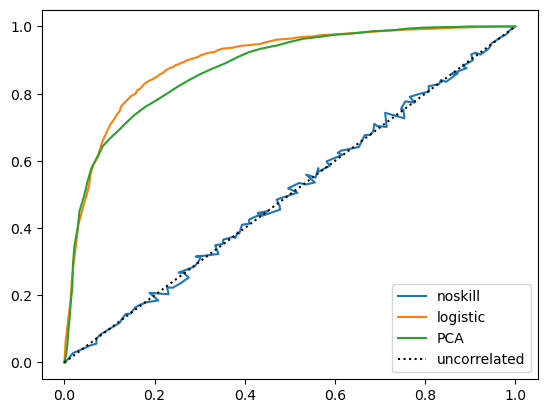

In [16]:
plt.plot(1 - Metrics_noskill[:, 1], Metrics_noskill[:, 0],label='noskill')
plt.plot(1 - Metrics_log[:, 1], Metrics_log[:, 0],label=f'logistic')
plt.plot(1 - Metrics_pca[:, 1], Metrics_pca[:, 0],label=f'PCA')
plt.plot([0,1],[0,1],':',color='black', label='uncorrelated')
plt.legend()
plt.show()

One can characterize the performance using the AUC (the area under the curve)


In [17]:
from sklearn.metrics import auc

auc(1-Metrics_log[:,1], Metrics_log[:,0])

0.8957105752216716

## 6. Best parameters 

We can decide which is the best parameter by looking for the value for which we get quality values nearer to the perfect prediction, i.e. we can try to minimize 

$$dis=\sqrt{(Sen-1)^2+(1-Spe)^2)}$$

or maximize the distance to the uncorrelated threshold, the so-called Youden's index
$$Youden=Sen-(1-Spe)=Sen+Spe-1$$



In [18]:
Sen=Metrics_log[:,0]
Spe=Metrics_log[:,1]

dis=np.sqrt((Sen-1)**2+(1-Spe)**2)
Youden=Sen+Spe-1

#最小化dis的参数
best_dis_param = range_log[np.argmin(dis)]

#最大化Youden的参数
best_Youden_param = range_log[np.argmax(Youden)]

print(f"Best parameter (minimizing dis): {best_dis_param}")
print(f"Best parameter (maximizing Youden): {best_Youden_param}")

Best parameter (minimizing dis): 0.696969696969697
Best parameter (maximizing Youden): 0.696969696969697


Extract the best parameters for the PCA and the Logistic regression and compare the quality metrics using these parameters with those discussed above

In [20]:
# PCA的最值 (最小化 Youden)
PCA_param = range_pca[np.argmax(Youden)]

# Logistic回归的最值 (最小化dis)
Logistic_param = range_log[np.argmin(dis)]

#PCA
X_pred_pca = PCA_based(X_test, threshold=best_PCA_param)
Sen_pca, Spe_pca, Pre_pca, NPV_pca, Acc_pca, F1_pca = metrics(y_test, X_pred_pca)
#Logistic
y_probs_log = logistic(X_test, X_train, y_train)
y_pred_log = (y_probs_log[:, 1] > Logistic_param).astype(int)
Sen_log, Spe_log, Pre_log, NPV_log, Acc_log, F1_log_best = metrics(y_test, y_pred_log)


# 对比quality metrics
print("Quality Metrics for PCA with Best Parameter:")
print(f"Sensitivity (Recall): {Sen_pca}")
print(f"Specificity: {Spe_pca}")
print(f"Precision: {Pre_pca}")
print(f"Negative Predictive Value: {NPV_pca}")
print(f"Accuracy: {Acc_pca}")
print(f"F1 Score: {F1_pca}")

print("\nQuality Metrics for Logistic Regression with Best Parameter:")
print(f"Sensitivity (Recall): {Sen_log}")
print(f"Specificity: {Spe_log}")
print(f"Precision: {Pre_log}")
print(f"Negative Predictive Value: {NPV_log}")
print(f"Accuracy: {Acc_log}")
print(f"F1 Score: {F1_log}")

NameError: name 'best_PCA_param' is not defined